In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25

eeg_data_1 = pd.read_csv('data/muselsl-sample-10min-3.csv')
gradcpt_data_1 = pd.read_csv('data/gradcpt-sample-10min-3.csv')
eeg_data_2 = pd.read_csv('data/muselsl-sample-10min-4.csv')
gradcpt_data_2 = pd.read_csv('data/gradcpt-sample-10min-4.csv')
eeg_data_3 = pd.read_csv('data/muselsl-sample-10min-5.csv')
gradcpt_data_3 = pd.read_csv('data/gradcpt-sample-10min-5.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [2]:
eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

### z-normalization

In [3]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [4]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [5]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

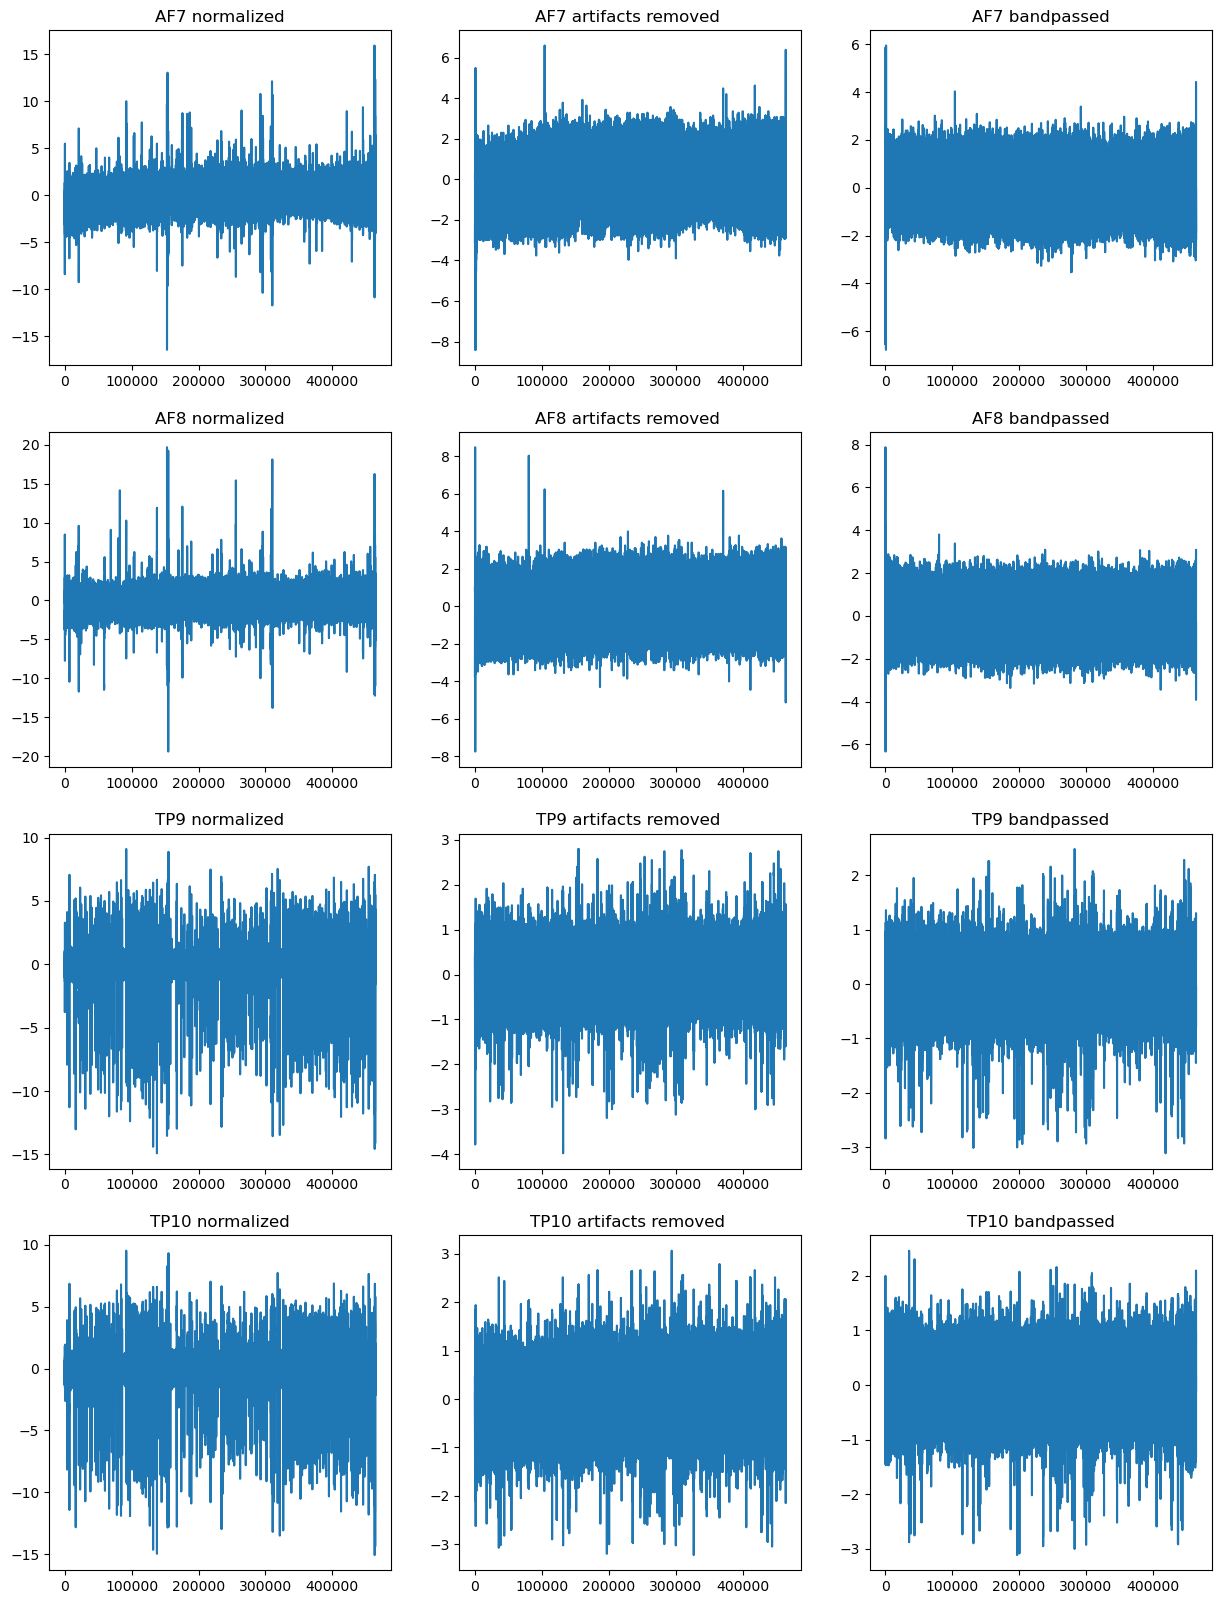

In [6]:
plt.figure(figsize=(15,20))

for i, channel in enumerate(channels):
    plt.subplot(4, 3, i*3+1)
    plt.plot(eeg_data[f'{channel}_normal'], label=f'{channel} normalized')
    plt.title(f'{channel} normalized')

    plt.subplot(4, 3, i*3+2)
    plt.plot(eeg_data[f'{channel}_artif_removed'], label=f'{channel} artifacts removed')
    plt.title(f'{channel} artifacts removed ')

    plt.subplot(4, 3, i*3+3)
    plt.plot(eeg_data[f'{channel}_bandpassed'], label=f'{channel} bandpassed')
    plt.title(f'{channel} bandpassed')

### Feature extraction

In [7]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

In [12]:
print(eeg_data_t3.shape)
print(gradcpt_data_t1.shape)
eeg_data_t1.head()

(153901, 19)
(745, 3)


,timestamps,TP9,AF7,AF8,TP10,Right AUX,is_mountain,AF7_normal,AF8_normal,TP9_normal,TP10_normal,AF7_artif_removed,AF8_artif_removed,TP9_artif_removed,TP10_artif_removed,AF7_bandpassed,AF8_bandpassed,TP9_bandpassed,TP10_bandpassed
0,1.710927e+09,-27.344,-33.203,-27.832,-30.762,0.0,0.0,0.047832,0.841366,0.389936,0.119817,0.047832,0.841366,0.389936,0.119817,-0.700435,-0.128817,-0.037617,0.016229
1,1.710927e+09,-35.156,-32.227,-26.367,-32.227,0.0,0.0,0.188684,1.065845,-0.002712,0.045035,0.188684,1.065845,-0.002712,0.045035,-1.199013,-0.491578,-0.122851,-0.163652
2,1.710927e+09,-30.762,-39.551,-32.715,-35.645,0.0,0.0,-0.868282,0.093154,0.218140,-0.129440,-0.868282,0.093154,0.218140,-0.129440,-1.648166,-0.791036,-0.242072,-0.327062
3,1.710927e+09,-26.855,-44.922,-35.156,-43.945,0.0,0.0,-1.643400,-0.280875,0.414514,-0.553121,-1.643400,-0.280875,0.414514,-0.553121,-1.801969,-0.870627,-0.372918,-0.406675
4,1.710927e+09,-39.551,-39.062,-31.738,-36.621,0.0,0.0,-0.797712,0.242858,-0.223614,-0.179260,-0.797712,0.242858,-0.223614,-0.179260,-1.462575,-0.691105,-0.439387,-0.349941


In [ ]:
# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [1, 2, 3]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

9/12 Done


/home/henri/miniconda3/envs/training-env/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 205, using nperseg = 205
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


In [ ]:
combined_features_df = pd.concat([features_t2, features_t3], ignore_index=True)

In [13]:
combined_features_df.shape()

NameError: name 'combined_features_df' is not defined

In [28]:
def train(runs, num_features):
    results = []
    
    for _ in range(runs):
        from scipy.stats import ttest_ind
        from sklearn.model_selection import StratifiedKFold, GridSearchCV
        from sklearn.metrics import balanced_accuracy_score
        from sklearn.svm import SVC
        
        features = combined_features_df.iloc[:, :-1].values
        labels = combined_features_df.iloc[:, -1].values
        
        def select_top_features(X, y, num_features=num_features):
            # Perform a t-test across features
            t_stats, p_values = ttest_ind(X[y == 0], X[y == 1], axis=0)
            # Select indices of top features based on smallest p-values
            top_features_indices = np.argsort(np.abs(t_stats))[-num_features:]
            return top_features_indices
        
        outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
        
        balanced_acc_scores = []
        
        for train_index, test_index in outer_cv.split(features, labels):
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
        
            # Feature selection for the outer fold
            top_features_indices = select_top_features(X_train, y_train)
            X_train_selected = X_train[:, top_features_indices]
            X_test_selected = X_test[:, top_features_indices]
        
            # Inner CV for hyperparameter truning
            inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}
            grid_search = GridSearchCV(SVC(), param_grid, cv=inner_cv, scoring='balanced_accuracy')
            grid_search.fit(X_train_selected, y_train)
        
            best_model = grid_search.best_estimator_
            
        
            balanced_acc = balanced_accuracy_score(y_test, best_model.predict(X_test_selected))
            balanced_acc_scores.append(balanced_acc)
        
        final_performance = np.mean(balanced_acc_scores)
        results.append(round(final_performance, 3))
    print(f'Runs: {results}')
    print(f'Avg: {sum(results) / len(results)}')

In [29]:
for feats in [1, 5, 10, 15, 20, 25, 30]:
    print(f'---{feats} features---')
    train(runs=5, num_features=feats)

---1 features---
Runs: [0.56, 0.55, 0.578, 0.563, 0.528]
Avg: 0.5558000000000001
---5 features---
Runs: [0.561, 0.586, 0.573, 0.581, 0.572]
Avg: 0.5746
---10 features---
Runs: [0.58, 0.576, 0.606, 0.568, 0.588]
Avg: 0.5836
---15 features---
Runs: [0.595, 0.595, 0.597, 0.578, 0.6]
Avg: 0.593
---20 features---
Runs: [0.601, 0.595, 0.601, 0.604, 0.595]
Avg: 0.5992
---25 features---
Runs: [0.611, 0.601, 0.603, 0.613, 0.612]
Avg: 0.608
---30 features---
Runs: [0.606, 0.601, 0.593, 0.622, 0.601]
Avg: 0.6045999999999999
